### Load data from S3

In [2]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import numpy as np
from matplotlib.pyplot import figure

train_data_location = ''
test_data_location = ''
submission_location = ''

In [3]:
df_train = pd.read_csv(train_data_location)
df_test = pd.read_csv(test_data_location)
df_submission = pd.read_csv(submission_location)

In [4]:
df_train['timestamp']=pd.to_datetime(df_train['timestamp'])
df_test['timestamp']=pd.to_datetime(df_test['timestamp'])

In [5]:
df_train.shape, df_test.shape

((14963318, 18), (30750089, 18))

In [6]:
df_train.columns

Index(['Unnamed: 0', 'building_id', 'meter', 'timestamp', 'meter_reading',
       'site_id', 'primary_use', 'square_feet', 'air_temperature',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [7]:
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [8]:
df_test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour
0,129,0,0,2017-01-01 01:00:00,0,Education,7432,17.8,12.8,0.0,1022.0,130.0,3.1,2017,1,1,1
1,130,1,0,2017-01-01 01:00:00,0,Education,2720,17.8,12.8,0.0,1022.0,130.0,3.1,2017,1,1,1
2,131,2,0,2017-01-01 01:00:00,0,Education,5376,17.8,12.8,0.0,1022.0,130.0,3.1,2017,1,1,1
3,132,3,0,2017-01-01 01:00:00,0,Education,23685,17.8,12.8,0.0,1022.0,130.0,3.1,2017,1,1,1
4,133,4,0,2017-01-01 01:00:00,0,Education,116607,17.8,12.8,0.0,1022.0,130.0,3.1,2017,1,1,1


### EDA


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

Text(0.5, 1.0, 'building_primary_usage_by_count')

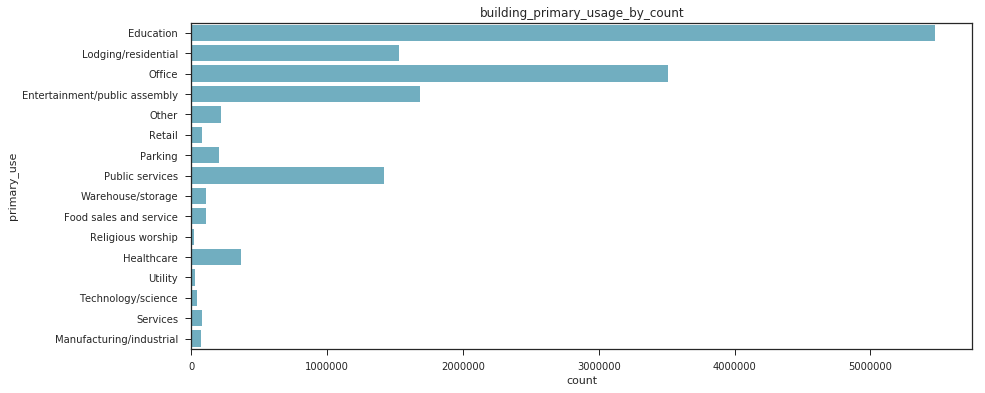

In [10]:
# Primary use chart
f, ax = plt.subplots(figsize=(14, 6))
sns.countplot(y='primary_use', data=df_train, color="c").set_title('building_primary_usage_by_count')

In [11]:
# meter reading by building ID
df_train['building_id'].unique()

array([  0,   1,   2, ..., 591, 783, 403])

In [12]:
def plot_meter_reading_by_meter_and_building_id(meter_id, building_id):
    df_filter = df_train[df_train.meter==meter_id]
    print(df_filter.shape)
    plt.figure(figsize=(50,10))
    plt.title("Meter Reading By Dates For Building " + str(building_id) + " of Meter " + str(meter_id),
              fontsize=40)
    plt.xlabel("Dates",fontsize=15)
    plt.ylabel("Meter Reading",fontsize=30)
    plt.xticks(fontsize=30, rotation=30)
    plt.yticks(fontsize=30)
    plt.plot(df_filter['timestamp'][df_filter.building_id==building_id],
             df_filter['meter_reading'][df_filter.building_id==building_id],
             linewidth=1.5)
    plt.show()

(8834616, 17)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


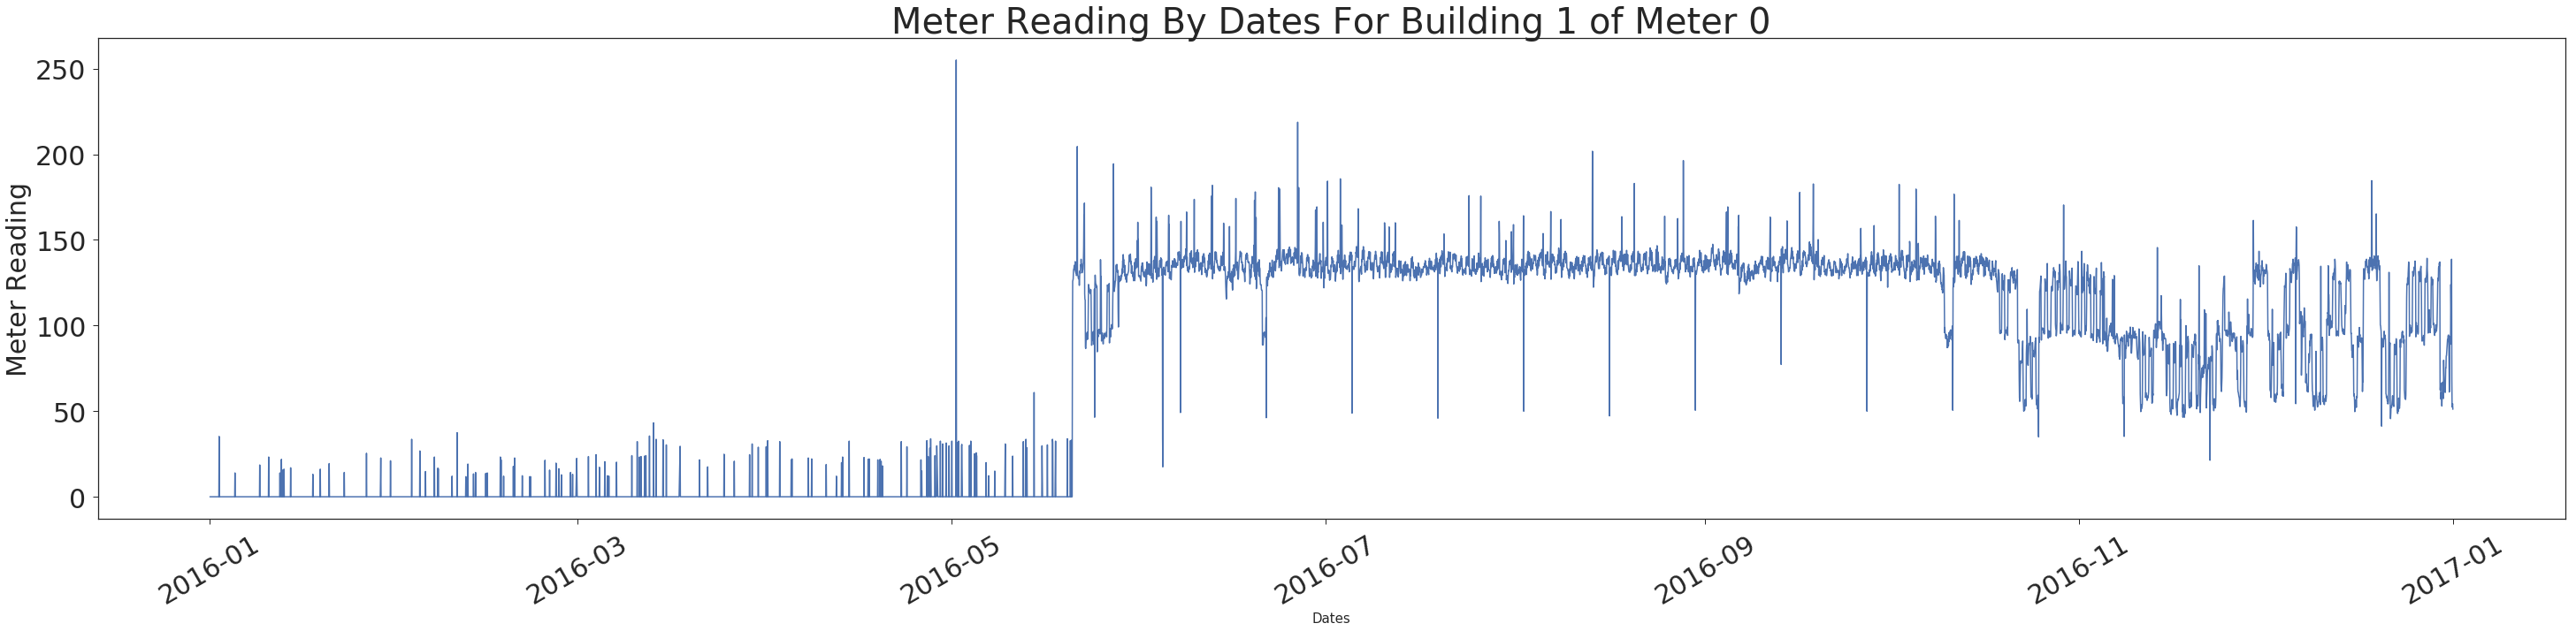

In [12]:
plot_meter_reading_by_meter_and_building_id(0, 1)

(3225977, 17)


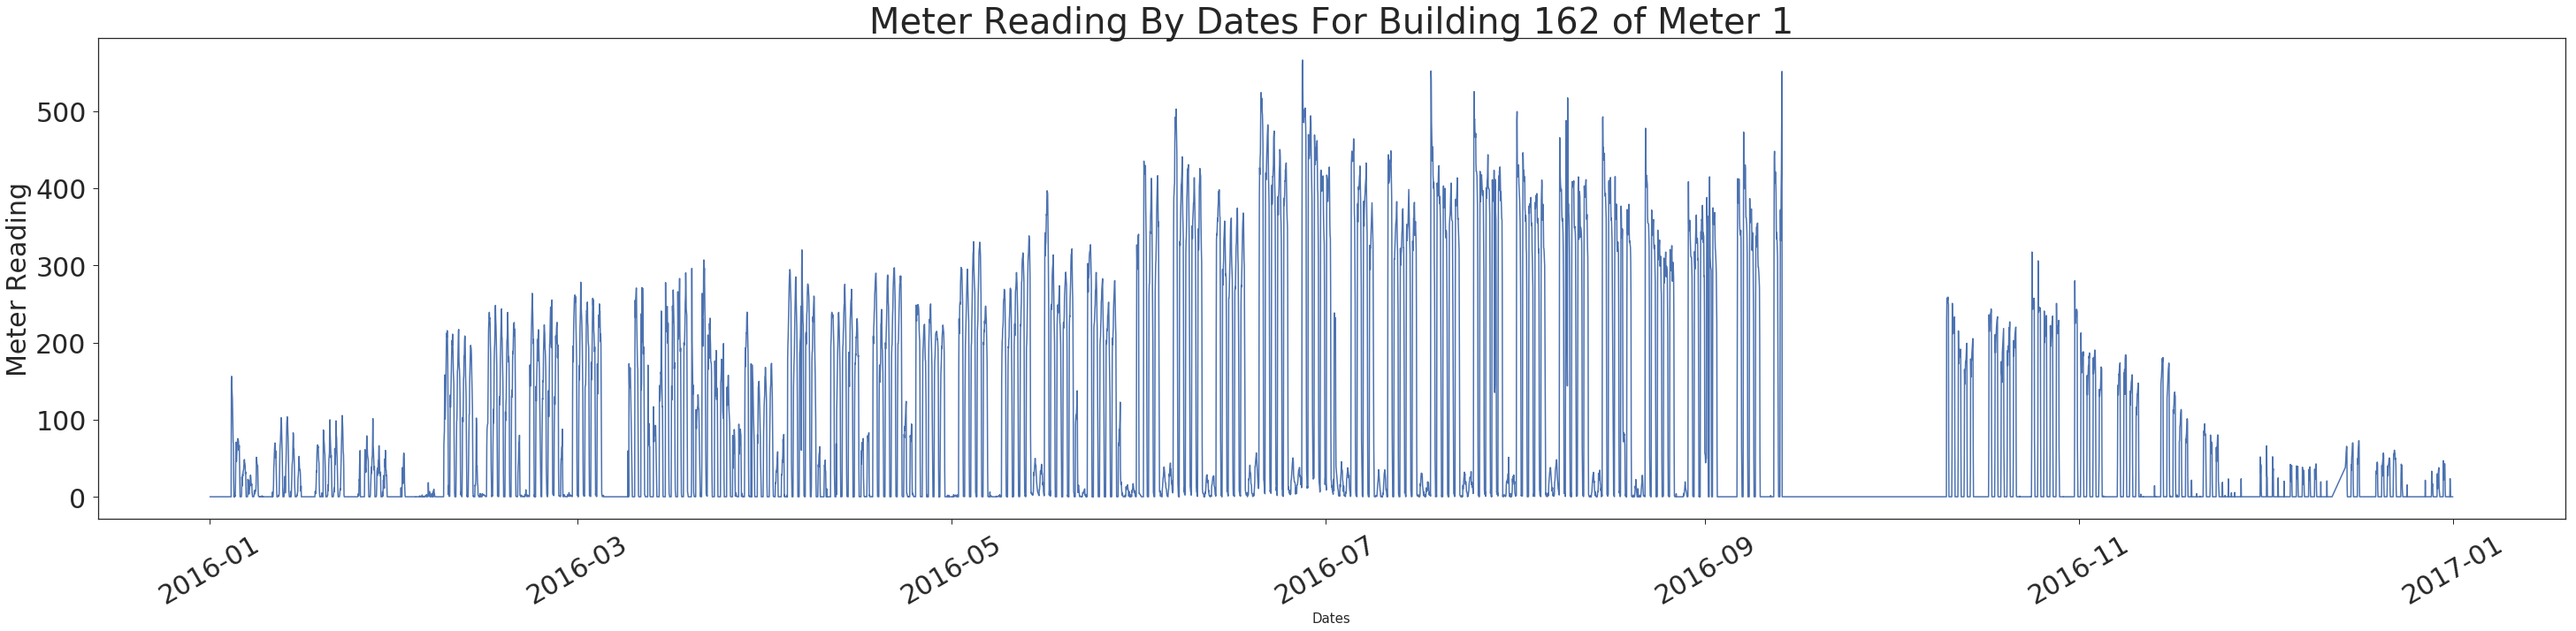

In [13]:
# df_train[df_train.meter==1]
plot_meter_reading_by_meter_and_building_id(1, 162)

(1889807, 17)


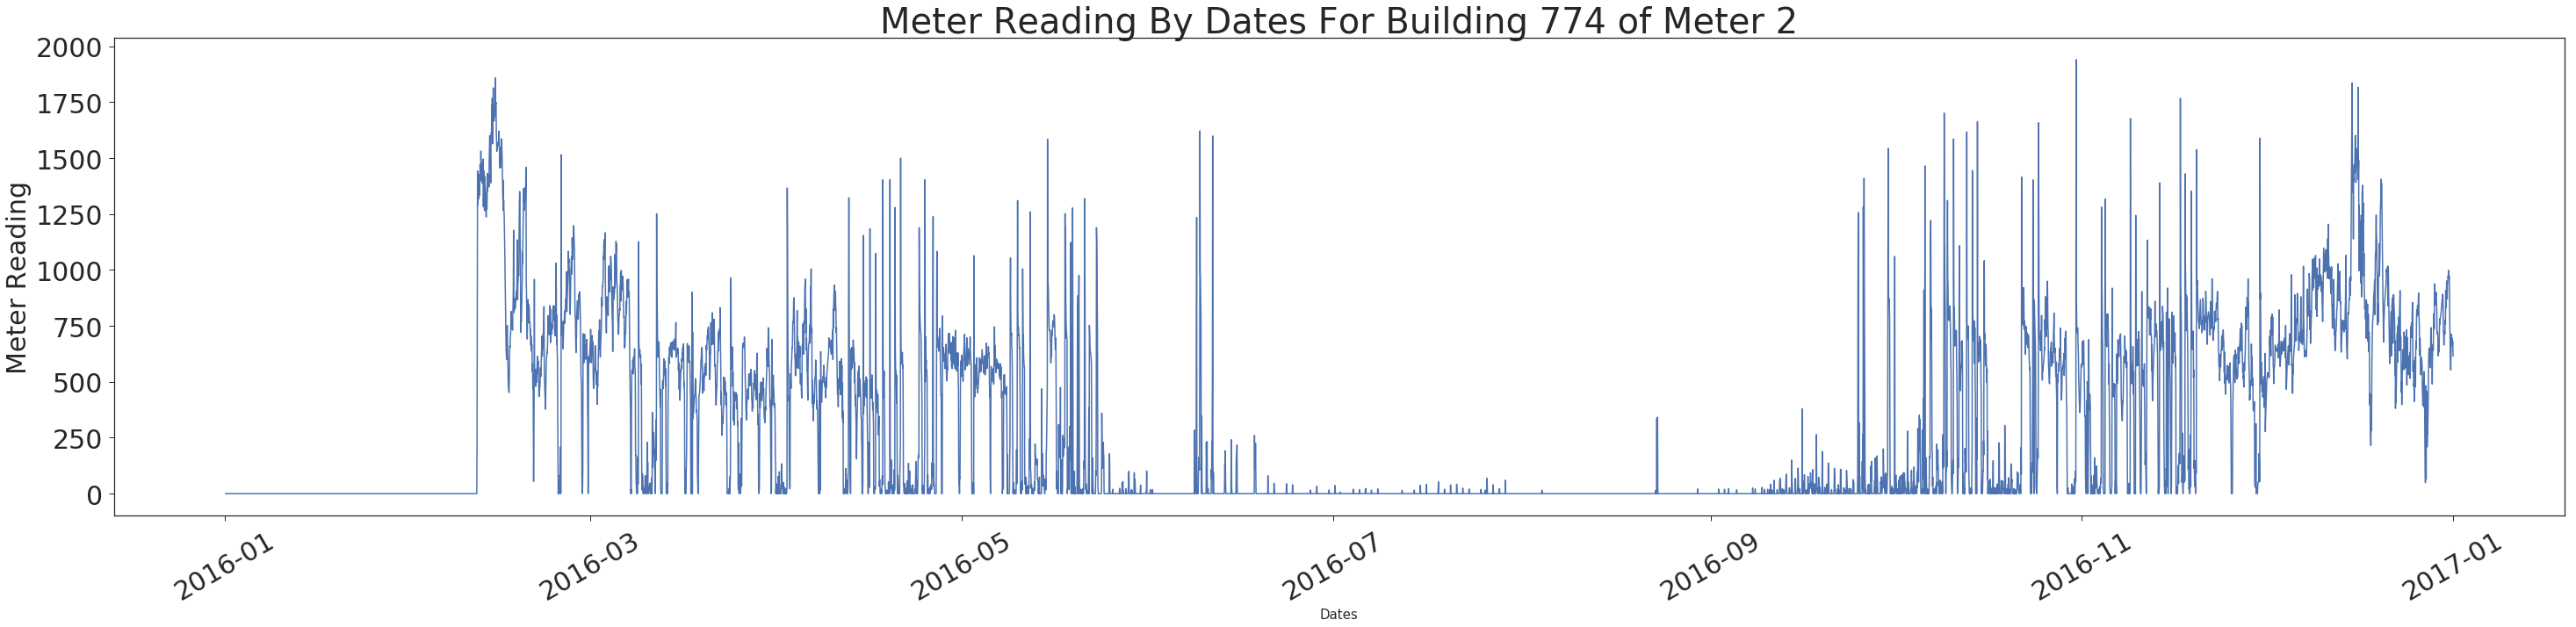

In [14]:
# df_train[df_train.meter==2]
plot_meter_reading_by_meter_and_building_id(2, 774)

(1012918, 17)


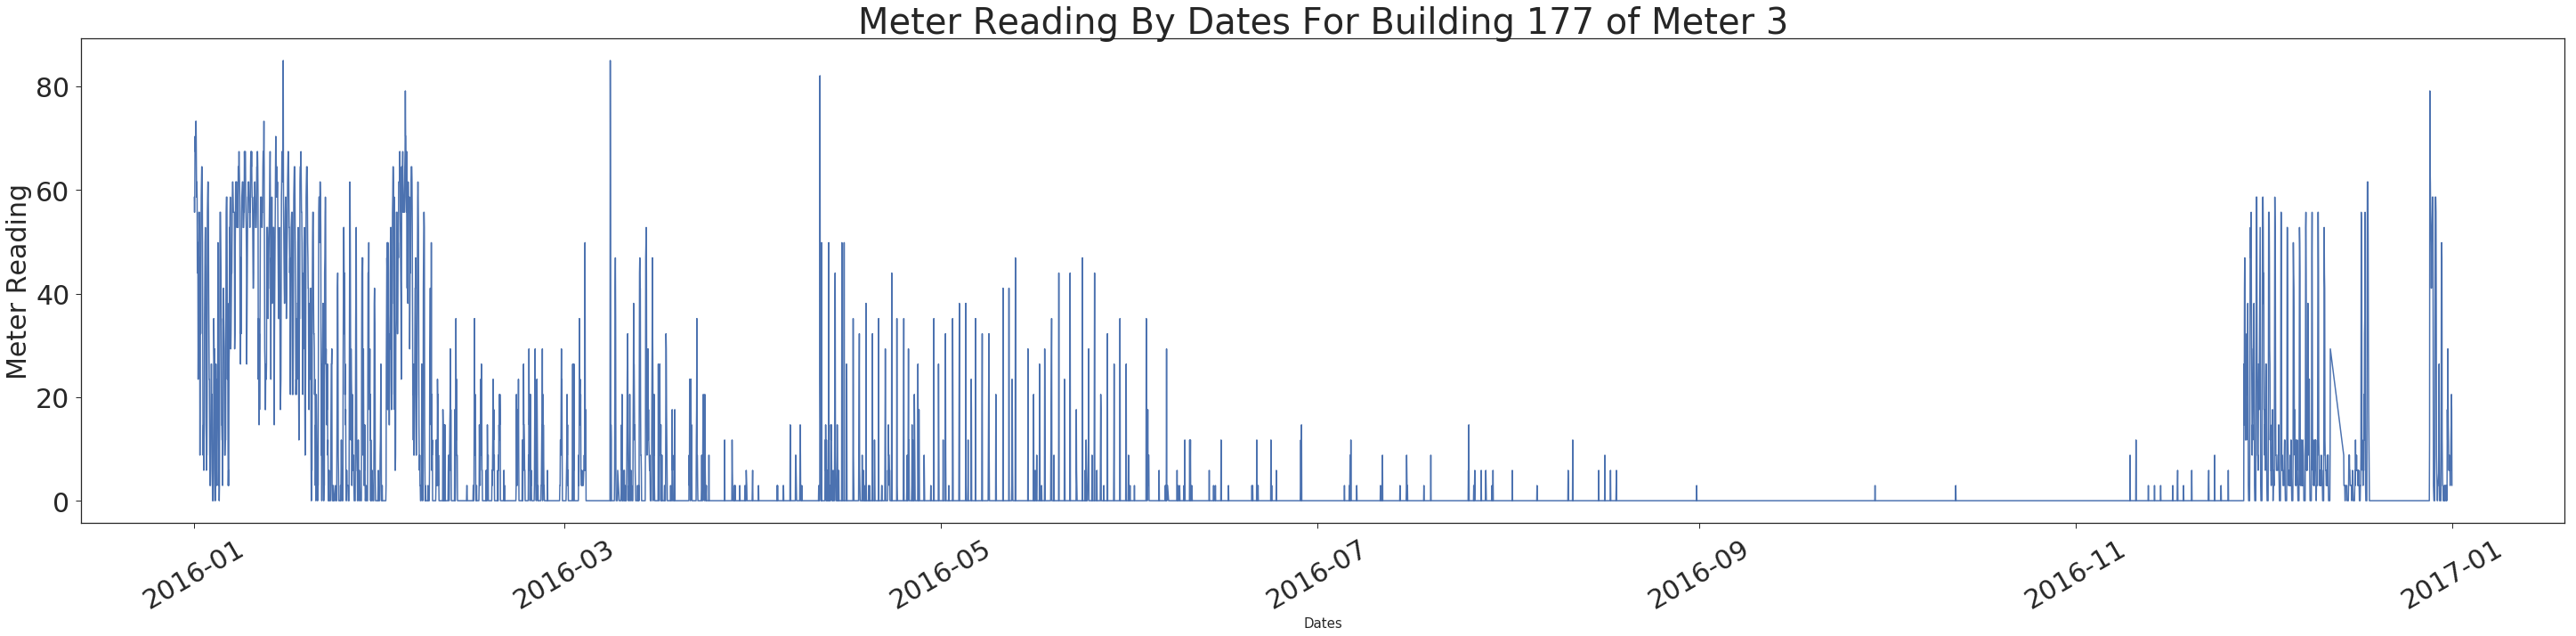

In [15]:
# df_train[df_train.meter==3]
plot_meter_reading_by_meter_and_building_id(3, 177)

In [16]:
print(df_train['site_id'].unique())
print(df_train['meter'].unique())

[ 0  2  3  4  6  8  9 10 13 14  7 11 15]
[0 1 3 2]


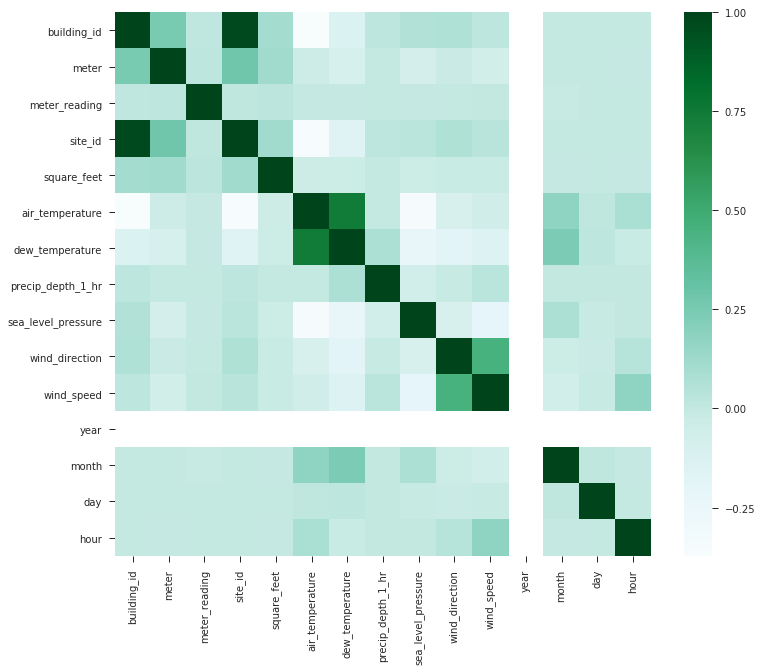

In [17]:
# Correlation Plot
plt.figure(figsize=(12, 10)) 
sns.heatmap(df_train.corr(), cmap='BuGn')

In [18]:
df_train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'year', 'month', 'day', 'hour'],
      dtype='object')

Text(0.5, 1.0, 'meter_reading_by_meter_type')

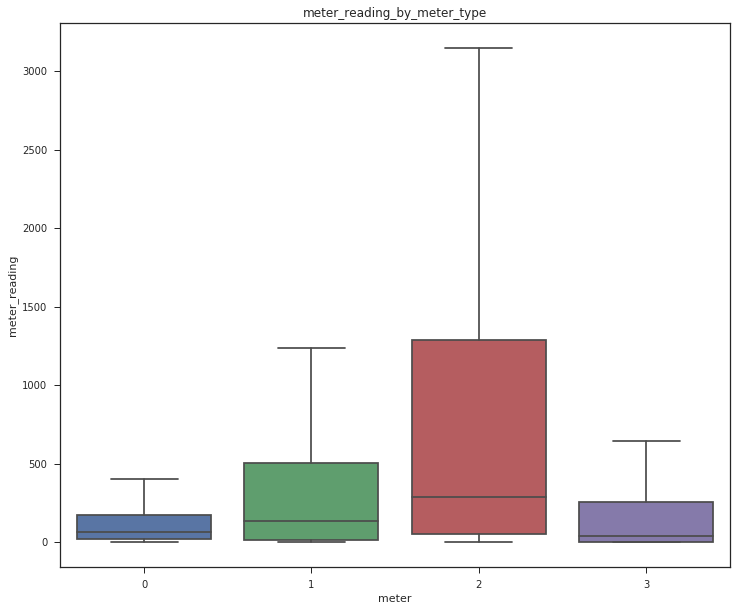

In [24]:
plt.figure(figsize=(12, 10)) 
sns.boxplot(x='meter', 
            y='meter_reading', 
            data=df_train, 
            showfliers=False).set_title('meter_reading_by_meter_type')

Text(0.5, 1.0, 'meter_reading_by_site_id')

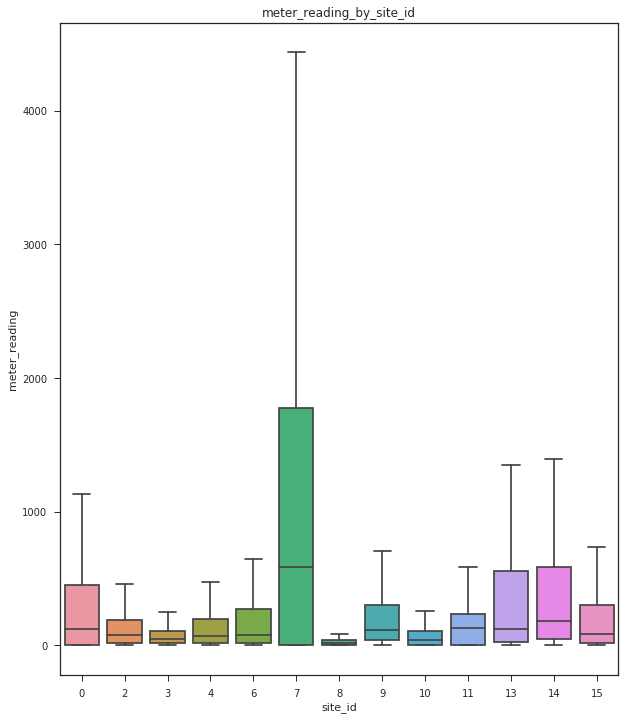

In [23]:
plt.figure(figsize=(10, 12)) 
sns.boxplot(x='site_id', 
            y='meter_reading', 
            data=df_train, 
            showfliers=False).set_title('meter_reading_by_site_id')

Text(0.5, 1.0, 'meter_reading_by_primary_use')

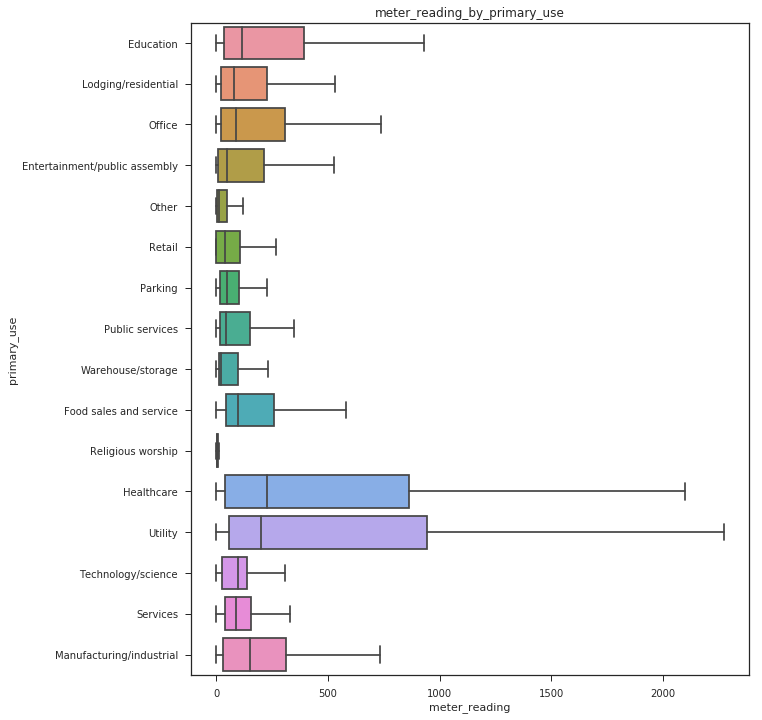

In [21]:
plt.figure(figsize=(10, 12))
sns.boxplot(y="primary_use", 
            x="meter_reading", 
            data=df_train, 
            showfliers=False).set_title('meter_reading_by_primary_use')

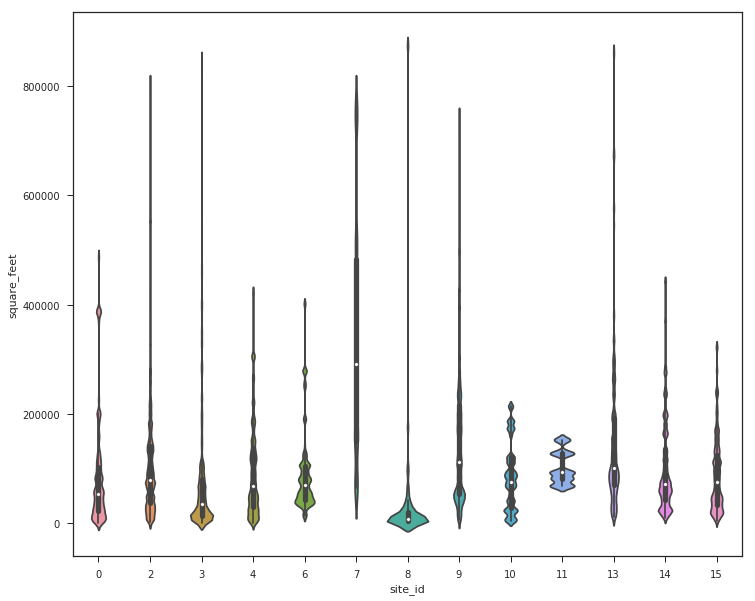

In [19]:
plt.figure(figsize=(12, 10)) 
sns.violinplot(x='site_id', y='square_feet', data=df_train)

In [20]:
df_train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [1]:
# sns.pairplot(df_train[['building_id', 'meter', 'site_id', 'primary_use', 'square_feet']])

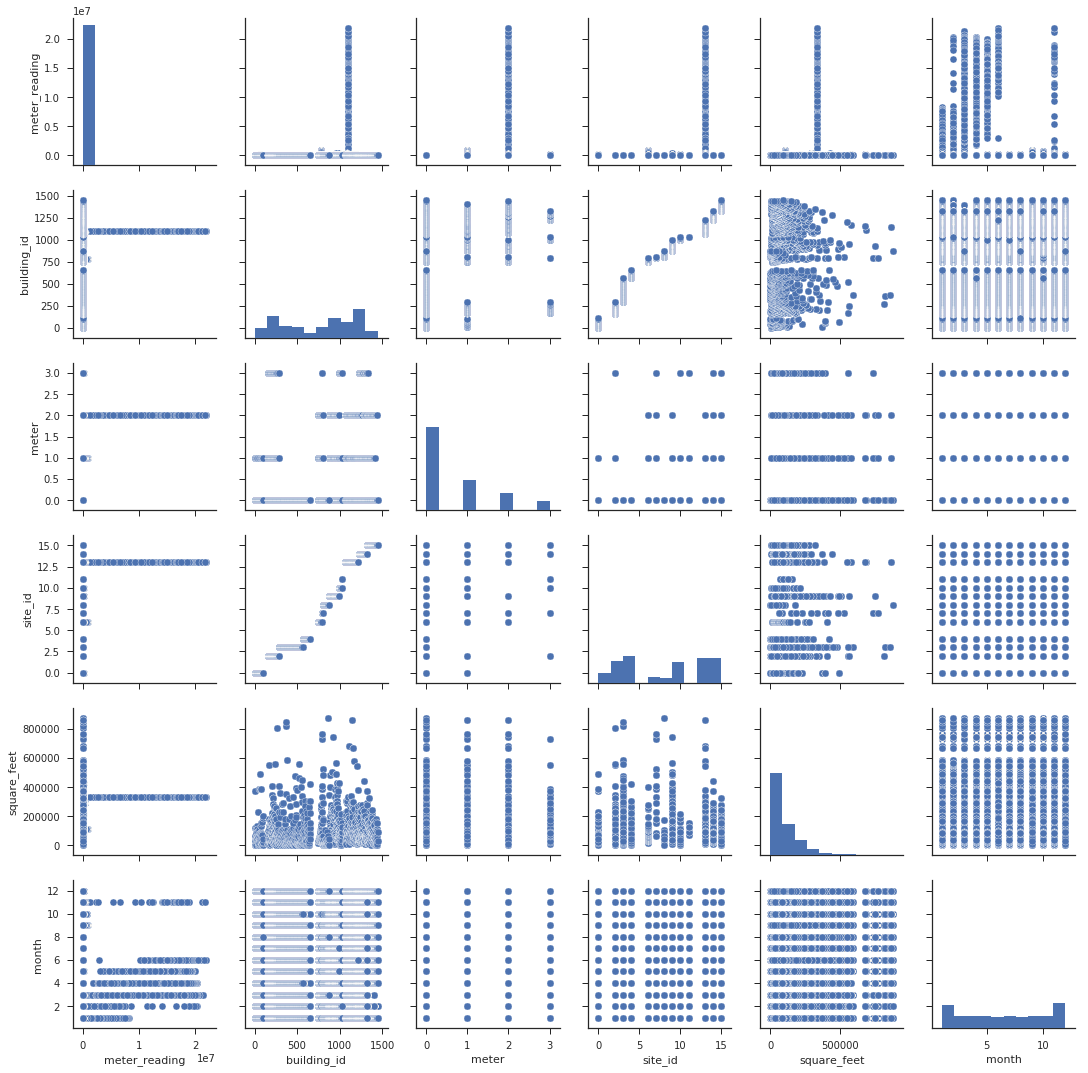

In [22]:
sns.pairplot(df_train[['meter_reading', 'building_id', 'meter', 'site_id', 'primary_use', 'square_feet', 'month']])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


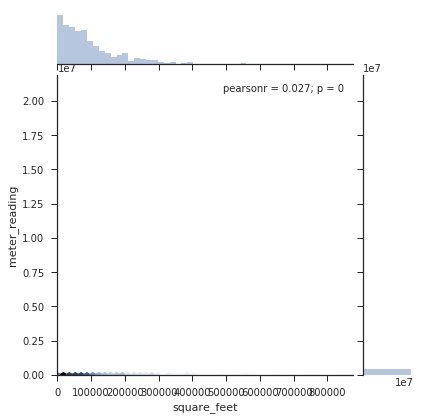

In [15]:
sns.jointplot(x='square_feet', 
              y='meter_reading', 
              kind="hex", 
              data=df_train)